In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

C:\Users\kacie\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [1124]:
import matplotlib.pyplot as plt

In [395]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [675]:
df = pd.read_csv("store_sales_cleaned_combined.csv")
df
#trainonly = pd.read_csv("train.csv")

,date,sales,onpromotion,oil_price
0,2013-01-01,2511.618999,0,93.14
1,2013-01-02,496092.417944,0,93.14
2,2013-01-03,361461.231124,0,92.97
3,2013-01-04,354459.677093,0,93.12
4,2013-01-05,477350.121229,0,93.12
...,...,...,...,...
1679,2017-08-11,826373.722022,14179,48.81
1680,2017-08-12,792630.535079,8312,48.81
1681,2017-08-13,865639.677471,9283,48.81
1682,2017-08-14,760922.406081,8043,47.59


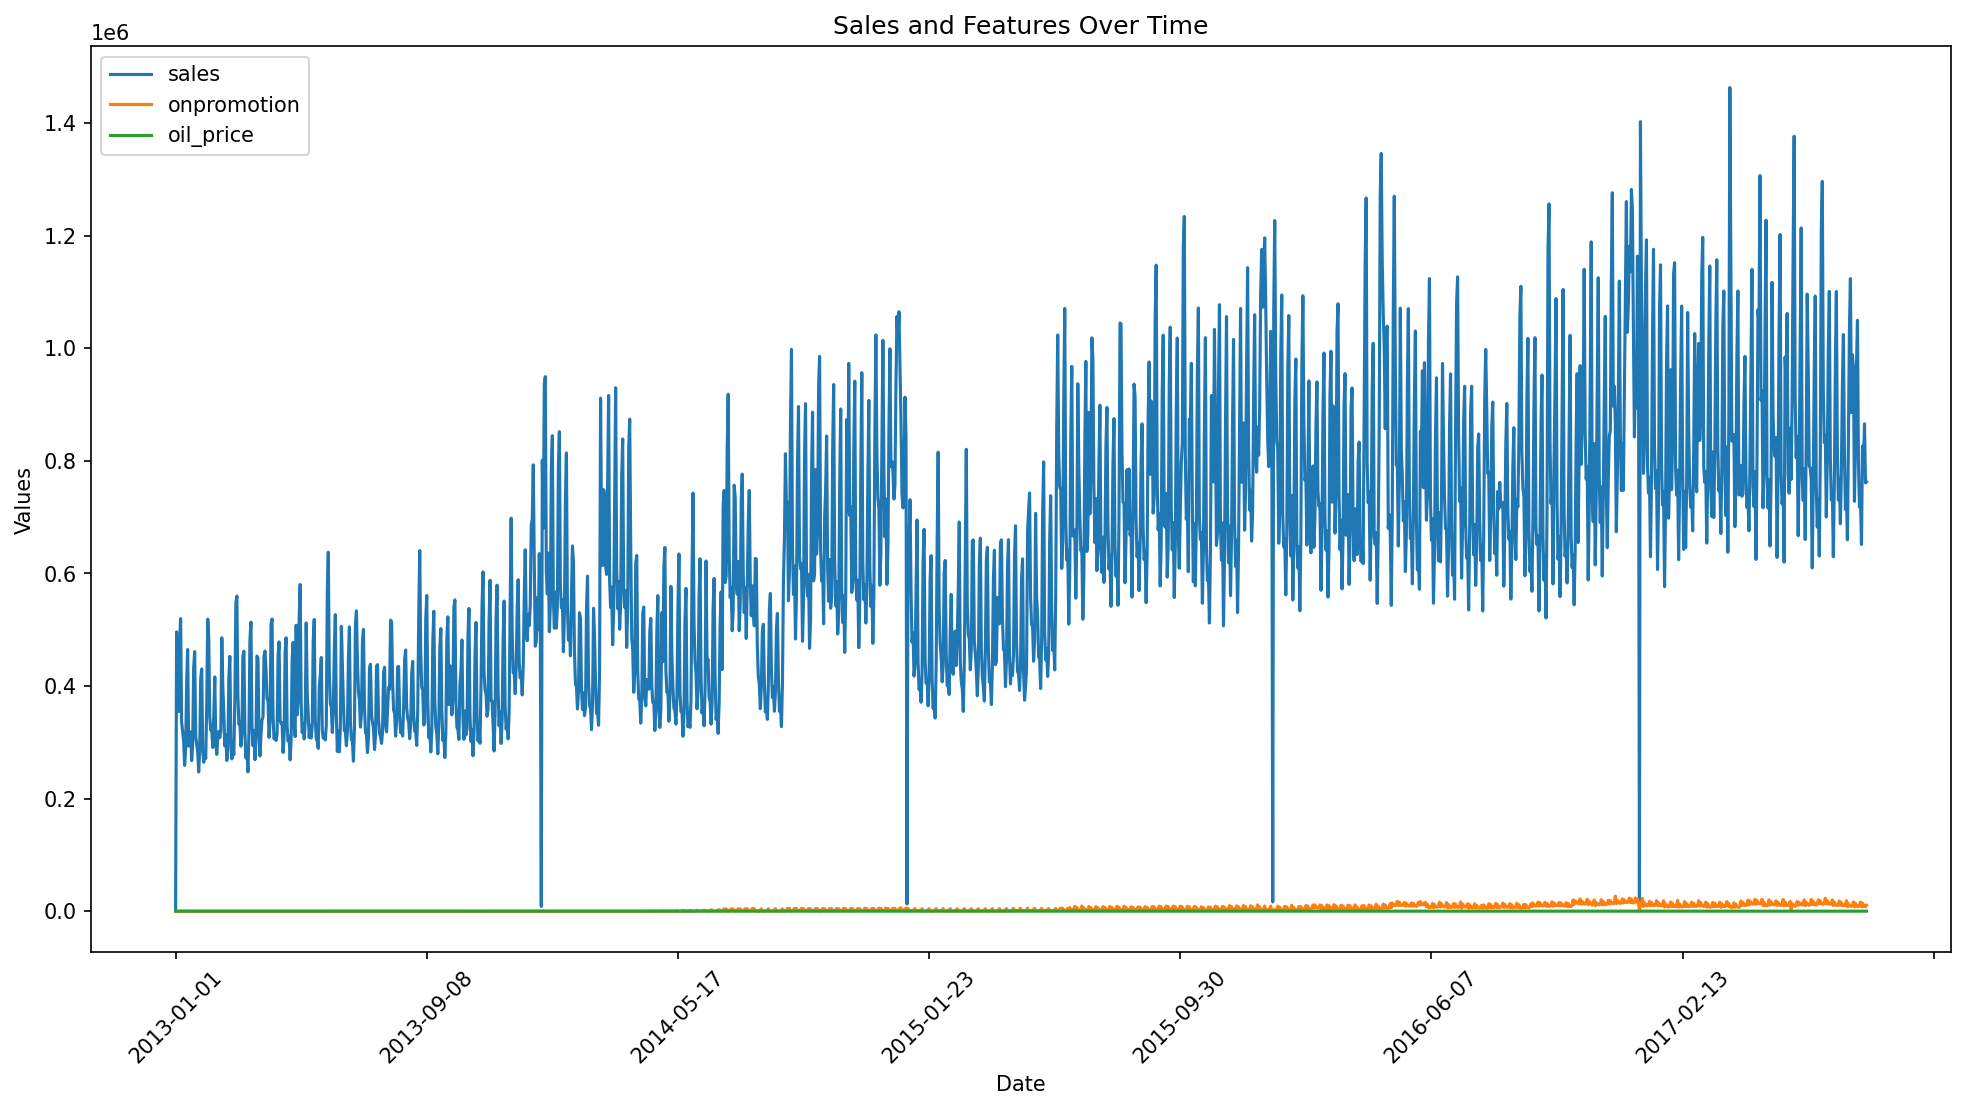

In [1119]:
#df.set_index('date', inplace=True)

# Plotting the lines
plt.figure(figsize=(16, 8), dpi=150)
df['sales'].plot(linestyle='-')
df['onpromotion'].plot(linestyle='-')
df['oil_price'].plot(linestyle='-')


# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Values')
plt.xticks(rotation = 45)
plt.title('Sales and Features Over Time')
plt.legend()  # Show legend with labels

# Show the plot
plt.show()

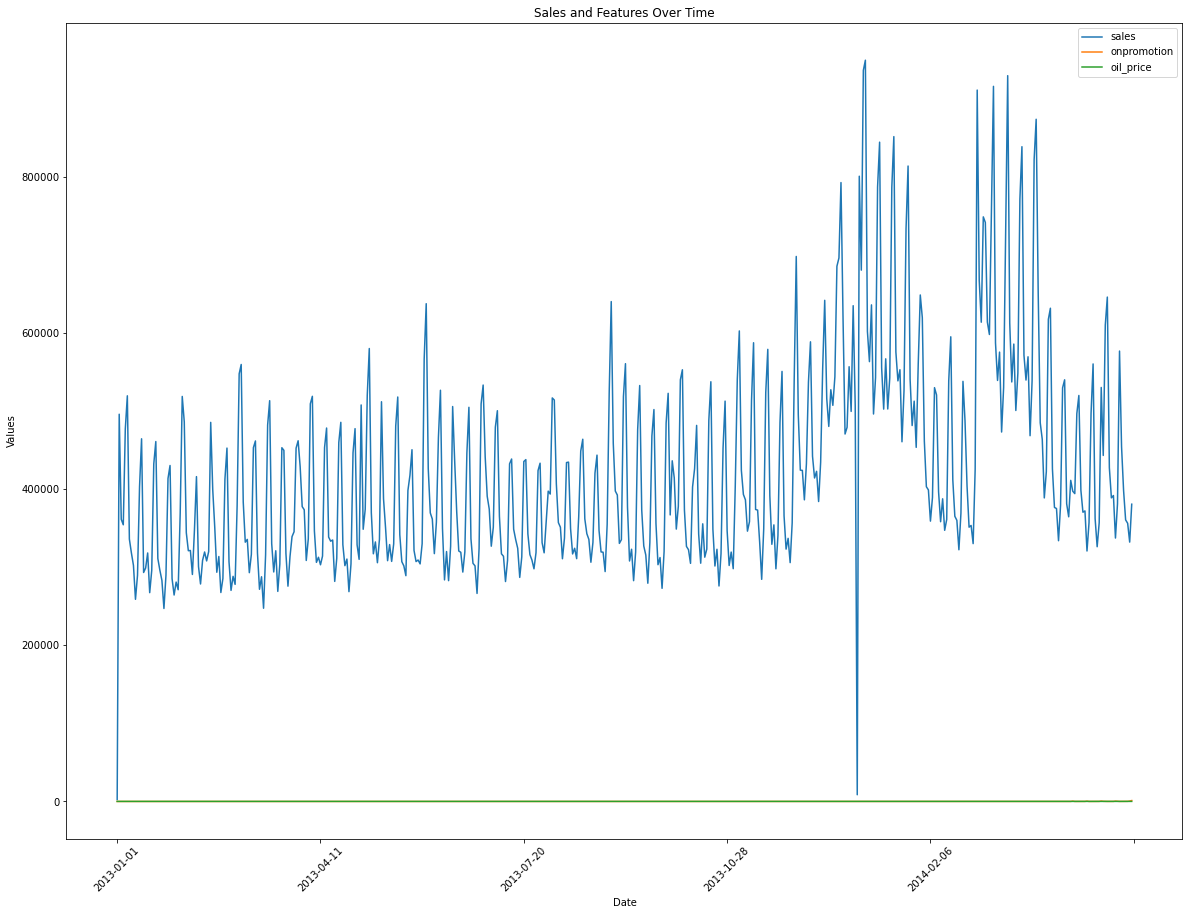

In [1123]:
#df.set_index('date', inplace=True)

# Plotting the lines
plt.figure(figsize=(20, 15))
df['sales'][0:500].plot(linestyle='-')
df['onpromotion'][0:500].plot(linestyle='-')
df['oil_price'][0:500].plot(linestyle='-')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Values')
plt.xticks(rotation = 45)
plt.title('Sales and Features Over Time')
plt.legend()  # Show legend with labels

# Show the plot
plt.show()

In [984]:
data_features = df.iloc[:, 1:4]

In [331]:
df[df['sales'] < 100000]

,date,sales,onpromotion,oil_price
0,2013-01-01,2511.618999,0,93.14
364,2014-01-01,8602.065404,0,98.17
728,2015-01-01,12773.616980,12,53.45
1092,2016-01-01,16433.394000,159,37.13
1457,2017-01-01,12082.500997,170,53.75


In [87]:
def get_x(data):
    sequence_length = 6
    sequences = [data[i:i+sequence_length] for i in range(len(data)-sequence_length-1)]
    X = np.array(sequences)
    return X

#used to look at the dates on data
def get_x_df(data):
    sequence_length = 6
    sequences = [data[i:i+sequence_length] for i in range(len(data)-sequence_length-1)]
    #X = np.array(sequences)
    return sequences

In [93]:
def get_y(data):
    sequence_length = 6
    sequences = [data[i:i+sequence_length] for i in range(len(data)-sequence_length)]
    y = []
    for i in range(1,len(sequences)):
        y.append(sequences[i].iloc[5]['sales'])
    return np.array(y)

#used to look at the dates on data
def get_y_df(data):
    y = []
    for i in range(1,len(sequences)):
        y.append([sequences[i].iloc[5]['date'],sequences[i].iloc[5]['sales']])
    return y

In [85]:
def normalize(df):
    df_norm = (df-df.min())/(df.max()-df.min())
    return df_norm

In [1161]:
X = get_x(normalize(data_features))
y = get_y(normalize(data_features))

In [1162]:
#last 15 days of testing data
test_x = X[1661:1676]
test_y = y[1661:1676]

In [1190]:
def make_df(y_pred,test_y):
    dic={'prediction': y_pred.reshape(len(y_pred)), 'actual': test_y}
    pred_act = pd.DataFrame(dic)
    return pred_act


def unnormalize(test_df, original_df):
    unnorm_df = test_df * (original_df.max()-original_df.min()) + original_df.min()
    return unnorm_df

def calc_metrics(df):
    rmse = np.sqrt(sum((df['actual']-df['prediction'])**2)/len(df))
    mse = sum((df['actual']-df['prediction'])**2)/len(df)
    mae = sum(np.abs(df['actual']-df['prediction']))/len(df)
    rmse_norm = rmse/df['actual'].max()
    mse_norm = mse/df['actual'].max()
    mae_norm = mae/df['actual'].max()
    df1 = pd.DataFrame([{"RMSE": rmse, "MSE": mse,"MAE": mae, "RMSE normalized": rmse_norm,"MSE normalized": mse_norm, "MAE normalized": mae_norm}])
    return df1

In [1229]:
def calc_metrics_new(df):
    rmse = np.sqrt(sum((df['actual']-df['prediction'])**2)/len(df))
    mae = sum(np.abs(df['actual']-df['prediction']))/len(df)
    rmsle = np.sqrt(sum((np.log(df['actual']+1)-np.log(df['prediction']+1))**2)/len(df))
    mape = sum(np.abs((df['actual']-df['prediction'])/df['actual']))/len(df) * 100
    overEstim=0
    underEstim=0
    for i in range(0,len(predictions_actual)):
        if predictions_actual.iloc[i]['actual'] < predictions_actual.iloc[i]['prediction']:
            overEstim += (1-0.5) * np.abs(predictions_actual.iloc[i]['actual'] - predictions_actual.iloc[i]['prediction'])
        else:
            underEstim += (0.5) * np.abs(predictions_actual.iloc[i]['actual'] - predictions_actual.iloc[i]['prediction'])
    quantile_loss = overEstim + underEstim
    df1 = pd.DataFrame([{"RMSE": rmse, "MAE": mae, "RMSLE": rmsle, "MAPE": mape, "Quantile Loss:": quantile_loss}])
    return df1

In [1166]:
X_train = X[0:1665]
y_train = y[0:1665]

In [1231]:
model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1,activation='linear'))

#optimizer = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)

#model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics = ['mse'])  # Use 'mse' for regression tasks

history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2, shuffle=True)

Epoch 1/200
42/42 [==============================] - 6s 31ms/step - loss: 0.1839 - mse: 0.1839 - val_loss: 0.1809 - val_mse: 0.1809
Epoch 2/200
42/42 [==============================] - 0s 6ms/step - loss: 0.0704 - mse: 0.0704 - val_loss: 0.0586 - val_mse: 0.0586
Epoch 3/200
42/42 [==============================] - 0s 6ms/step - loss: 0.0210 - mse: 0.0210 - val_loss: 0.0187 - val_mse: 0.0187
Epoch 4/200
42/42 [==============================] - 0s 5ms/step - loss: 0.0124 - mse: 0.0124 - val_loss: 0.0184 - val_mse: 0.0184
Epoch 5/200
42/42 [==============================] - 0s 5ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0199 - val_mse: 0.0199
Epoch 6/200
42/42 [==============================] - 0s 4ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0215 - val_mse: 0.0215
Epoch 7/200
42/42 [==============================] - 0s 5ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0221 - val_mse: 0.0221
Epoch 8/200
42/42 [==============================] - 0s 6ms/step - loss: 0.0105 - 

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


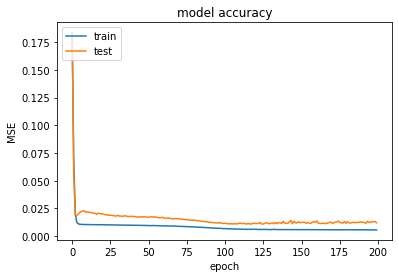

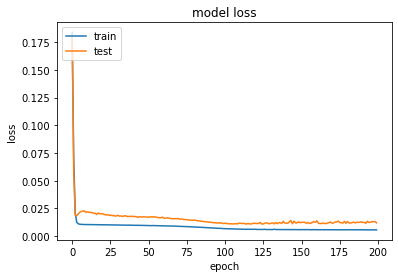

In [1232]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model accuracy')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [1233]:
y_pred = model.predict(test_x)

1/1 [==============================] - 1s 633ms/step


In [1234]:
predictions_actual = unnormalize(make_df(y_pred, test_y),data_features[1661:1676]['sales'])
#predictions_actual

In [1235]:
metrics = calc_metrics(predictions_actual)
metrics
#100 33647.063257
#50 33847.687786
#150 38013.115445
#200 35788.6477
#100 32038.095687

,RMSE,MSE,MAE,RMSE normalized,MSE normalized,MAE normalized,Quantile Loss:
0,36866.799417,1.359161e+09,25934.177492,0.036287,1337.789683,0.025526,177481.007389


In [1236]:
metrics1 = calc_metrics_new(predictions_actual)
metrics1

,RMSE,MAE,RMSLE,MAPE,Quantile Loss:
0,36866.799417,25934.177492,0.039452,2.72169,194506.331189


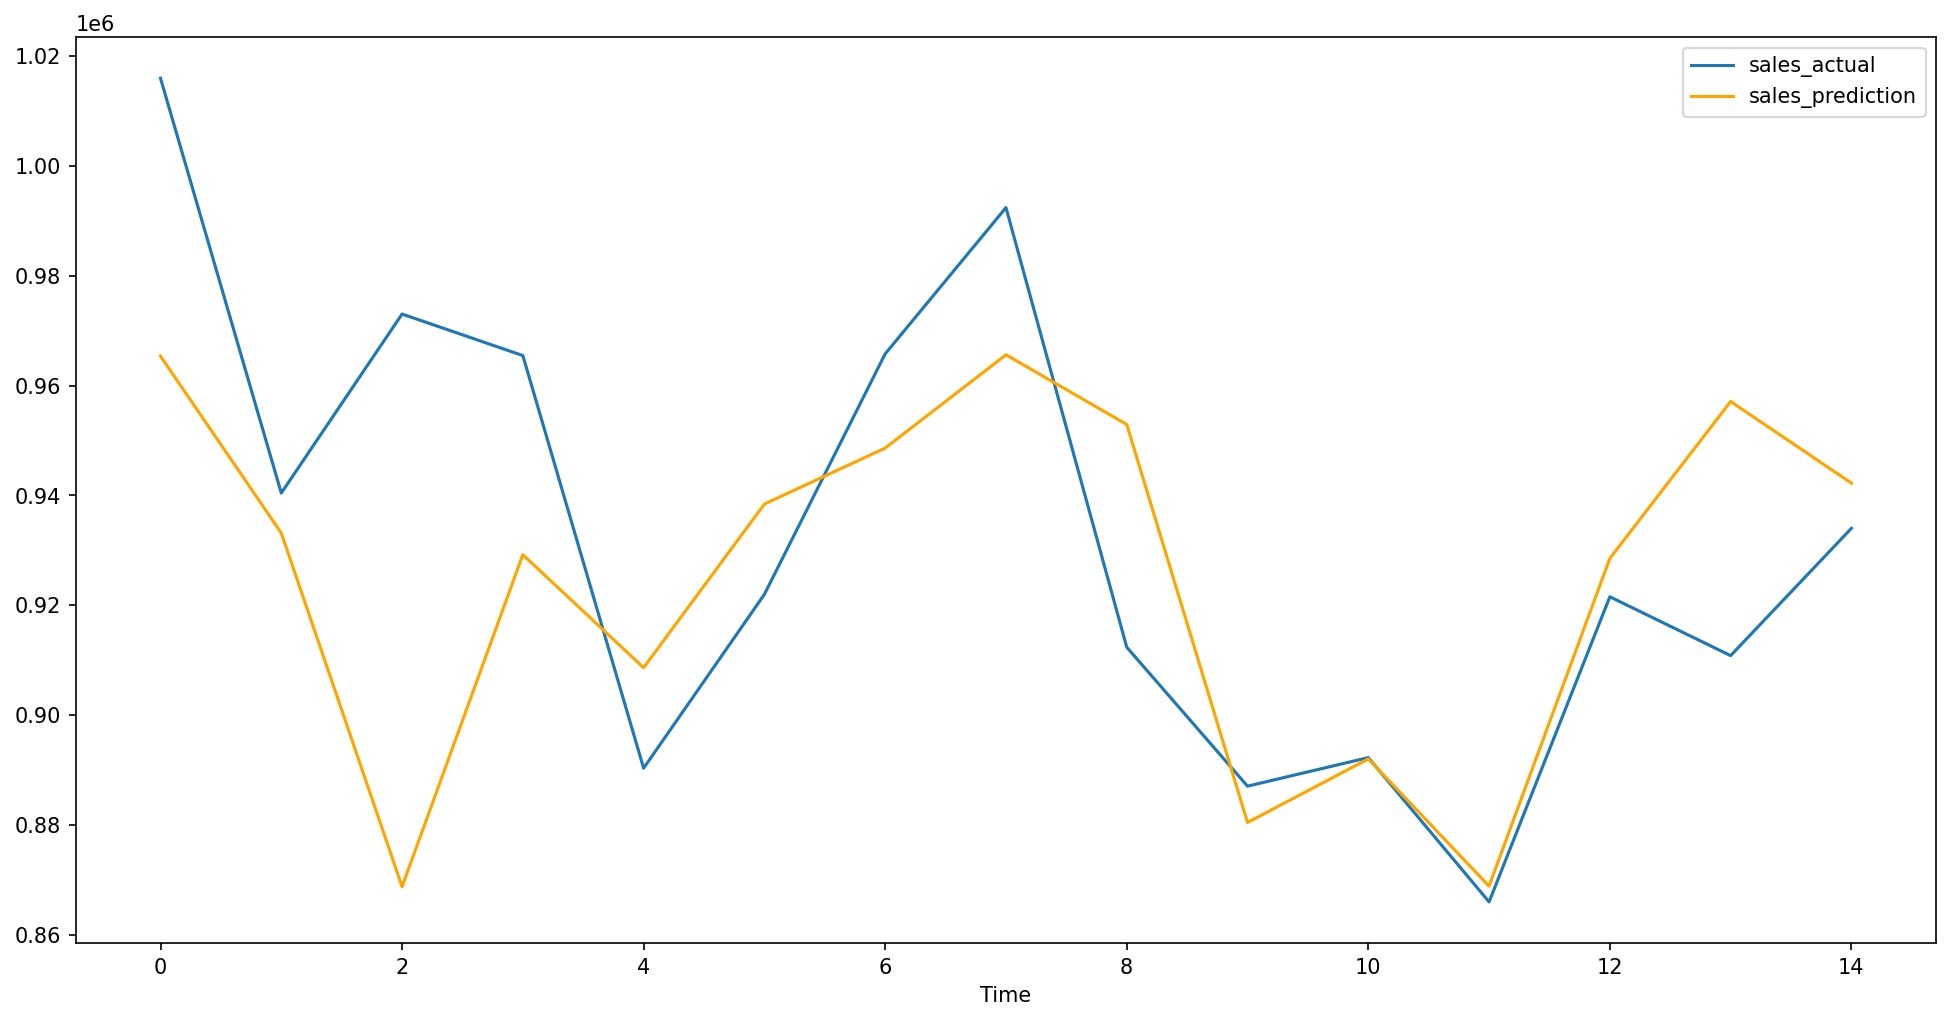

In [1237]:
plt.figure(figsize=(16, 8), dpi=150)
  
predictions_actual['actual'].plot(label='sales_actual')
predictions_actual['prediction'].plot(label='sales_prediction', color='orange')

# adding Label to the x-axis
plt.xlabel('Time')
  
# adding legend to the curve
plt.legend()

In [1174]:
model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = True))
model.add(LSTM(100, return_sequences = True))
model.add(LSTM(100))
model.add(Dense(1,activation='linear'))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics = ['mse'])
#model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mse'])  # Use 'mse' for regression tasks

history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2)

Epoch 1/200
42/42 [==============================] - 6s 37ms/step - loss: 0.1180 - mse: 0.1180 - val_loss: 0.1229 - val_mse: 0.1229
Epoch 2/200
42/42 [==============================] - 0s 10ms/step - loss: 0.0269 - mse: 0.0269 - val_loss: 0.0313 - val_mse: 0.0313
Epoch 3/200
42/42 [==============================] - 0s 10ms/step - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0185 - val_mse: 0.0185
Epoch 4/200
42/42 [==============================] - 0s 11ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0188 - val_mse: 0.0188
Epoch 5/200
42/42 [==============================] - 0s 11ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0192 - val_mse: 0.0192
Epoch 6/200
42/42 [==============================] - 0s 10ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0198 - val_mse: 0.0198
Epoch 7/200
42/42 [==============================] - 0s 10ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0185 - val_mse: 0.0185
Epoch 8/200
42/42 [==============================] - 0s 11ms/step - loss: 0.

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


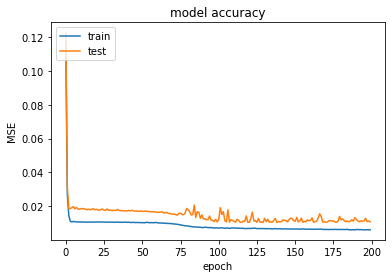

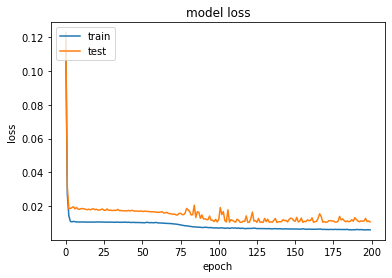

In [1175]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model accuracy')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [1176]:
y_pred = model.predict(test_x)

1/1 [==============================] - 1s 1s/step


In [1177]:
predictions_actual = unnormalize(make_df(y_pred, test_y),data_features[1661:1676]['sales'])

In [1178]:
#predictions_actual

In [1179]:
metrics = calc_metrics(predictions_actual)
metrics
#100,100 34081.645677
#100,50 31662.477867
#100, 150 33939.70692
#100, 50, 100 31640.174052
#100,50,50 33651.689035
#100,50,100 31483.57225
#100,100 29112.232536
#100,100,100 29790.953227

,RMSE,MSE,MAE,RMSE normalized,MSE normalized,MAE normalized
0,30818.056532,9.497526e+08,23664.134318,0.030333,934.818859,0.023292


In [1230]:
metrics1 = calc_metrics_new(predictions_actual)
metrics1

,RMSE,MAE,RMSLE,MAPE,Quantile Loss:
0,30818.056532,23664.134318,0.032414,2.471093,177481.007389


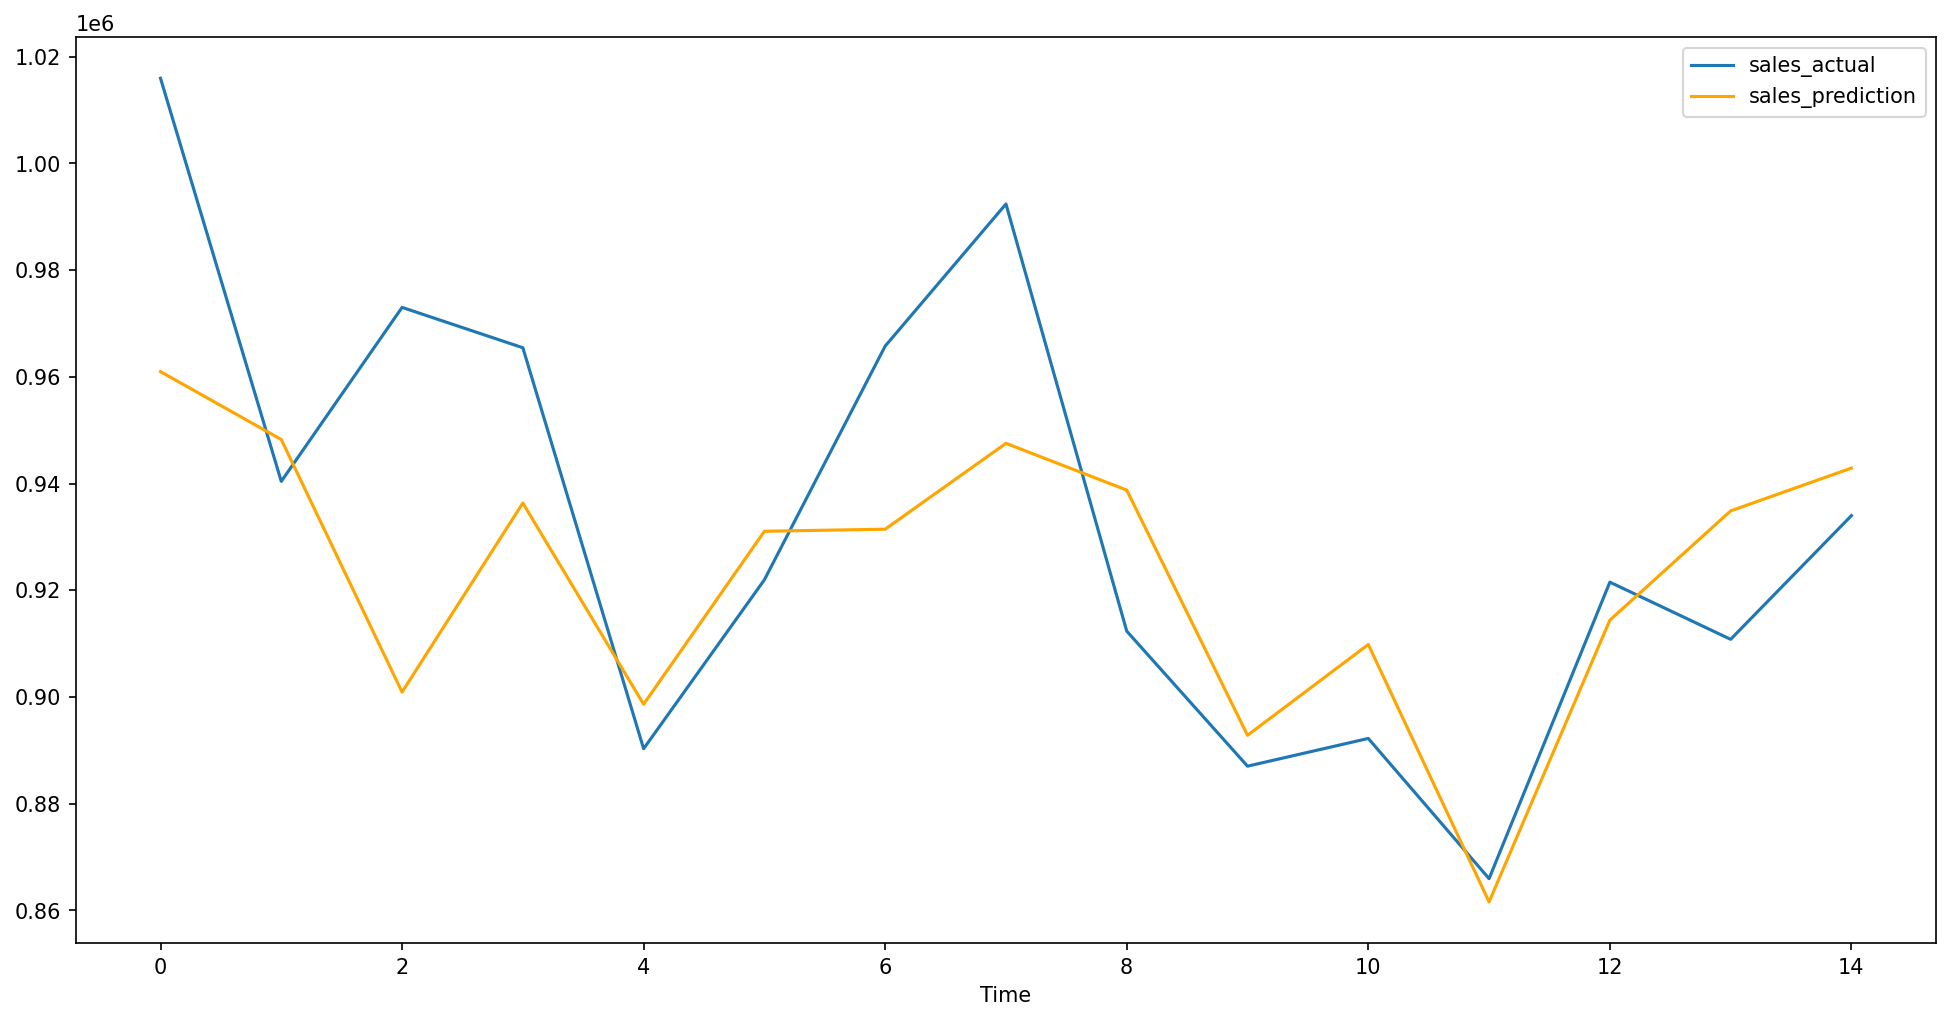

In [1181]:
plt.figure(figsize=(16, 8), dpi=150)
  
predictions_actual['actual'].plot(label='sales_actual')
predictions_actual['prediction'].plot(label='sales_prediction', color='orange')

# adding Label to the x-axis
plt.xlabel('Time')
  
# adding legend to the curve
plt.legend()